## This version does the ZOGY but computes the kernels in fourier space, and then convolves images in real space.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-16, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

Use the code from `diffimTests.py`.

In [3]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

# Generate images and PSF's with the same dimension as the image (used for A&L)
im1, im2, im1_psf, im2_psf, im1_var, im2_var, changedCentroid = \
    dit.makeFakeImages(imSize=(512, 512), sky=sky, psf1=None, psf2=None, offset=[0., 0.],
                    psf_yvary_factor=0., varSourceChange=1500., theta1=0., theta2=-45., im2background=0.,
                    n_sources=50, sourceFluxRange=(500,30000), seed=66, psfSize=None)

# This is a hack just to generate a pair of PSFs with size 50x50
_, _, P_r, P_n, _, _, changedCentroid = \
    dit.makeFakeImages(imSize=None, sky=sky, psf1=None, psf2=None, offset=[0., 0.],
                    psf_yvary_factor=0., varSourceChange=1500., theta1=0., theta2=-45., im2background=0.,
                    n_sources=5, sourceFluxRange=(500,30000), seed=66, psfSize=25)

print dit.computeClippedImageStats(im1)
print dit.computeClippedImageStats(im2)
print dit.computeClippedImageStats(im1_var)
print dit.computeClippedImageStats(im2_var)

LSSTSW has not been set up.
LSSTSW has not been set up.
Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: 0.0 0.0
Variable source: 245.899250131 279.361590046 1423.89964966 2923.89964966
Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: 0.0 0.0
Variable source: 245.221932537 348.22282075 6236.27669135 7736.27669135
(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16735074378053241, 17.213851327082029, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16735074378062, 17.213851327082025, 218.0, 1469.0572762553779)


In [4]:
reload(dit)
D = dit.performZOGY(im1, im2, im1_psf, im2_psf)
D_AL, _ = dit.performAlardLupton(im1, im2, spatialKernelOrder=0, spatialBackgroundOrder=1)
D_AL /= np.sqrt(sky * 2.)
D_new = dit.performZOGYImageSpace(im1, im2, P_r, P_n)
print dit.computeClippedImageStats(D)
print dit.computeClippedImageStats(D_new)
print dit.computeClippedImageStats(D_AL)

LSSTSW has not been set up.
(-0.00088461625274379168, 0.99323103779662691, -4.8991482476770942, 4.4838170921378442)
(-0.00093387909492429616, 0.99316652235136338, -4.8991388073481676, 4.4849793533753344)
(-0.0032262722462466469, 0.98514812124407647, -4.7392578761762429, 5.8009743431973506)


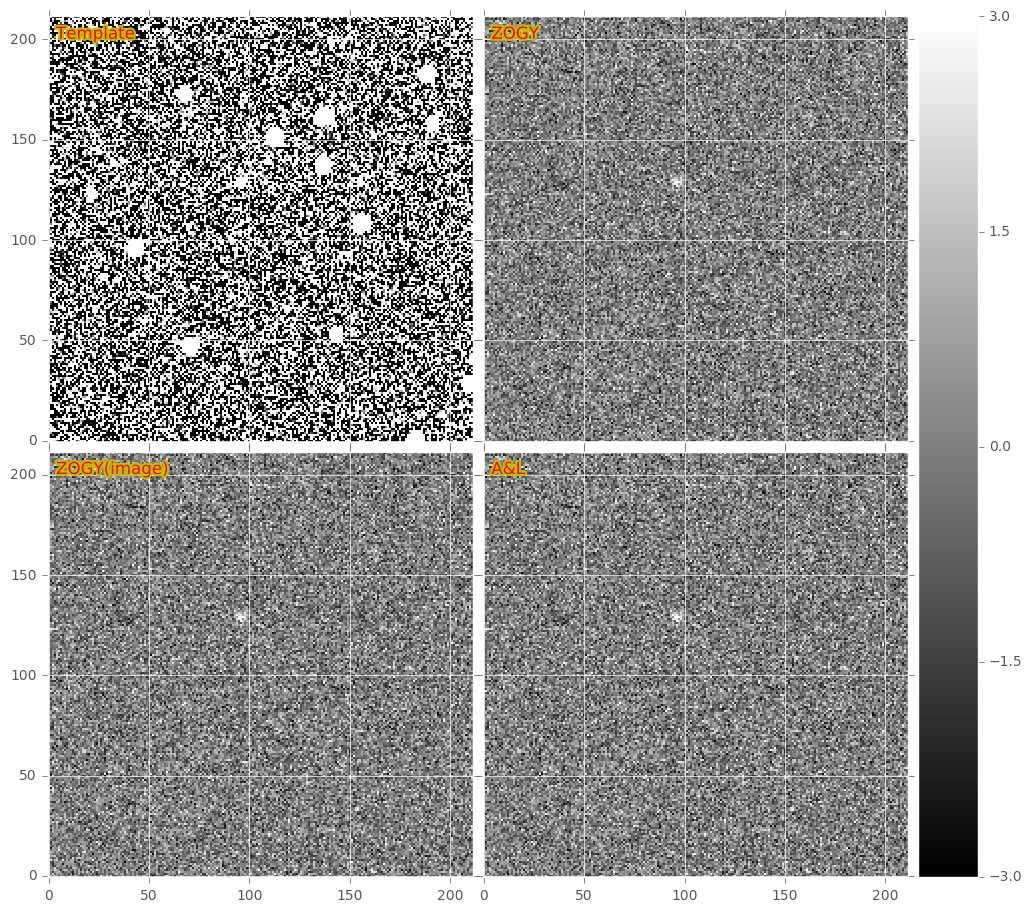

In [5]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
dit.plotImageGrid((im1[x1d:x2d,y1d:y2d], D[x1d:x2d,y1d:y2d], D_new[x1d:x2d,y1d:y2d], D_AL[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'ZOGY(image)', 'A&L'])

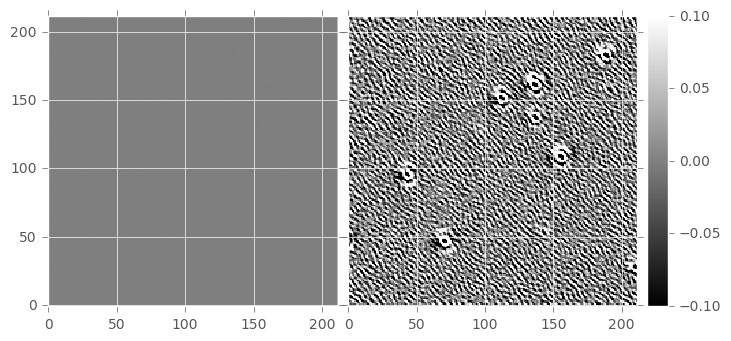

In [6]:
D_new[0,:] = D_new[:,0] = D_new[-1,:] = D_new[:,-1] = 0.
D[D_new == 0] = 0.
D_AL[D_new == 0] = 0.
fig = plt.figure(1, (8, 8))
dit.plotImageGrid(((D - D_new)[x1d:x2d,y1d:y2d], (D_new - D_AL)[x1d:x2d,y1d:y2d]), clim=(-0.1, 0.1))

Work on variance planes.

LSSTSW has not been set up.
(0.01078972482564104, 0.97870120675830719, -4.5284690834150716, 9.1272042650713381)
(6.9142543371464464e-05, 0.0061983037166391149, -0.028623117289243976, 0.063284775402083812)
(245.22193253733903, 348.22282075017586) 0.660360541329
29


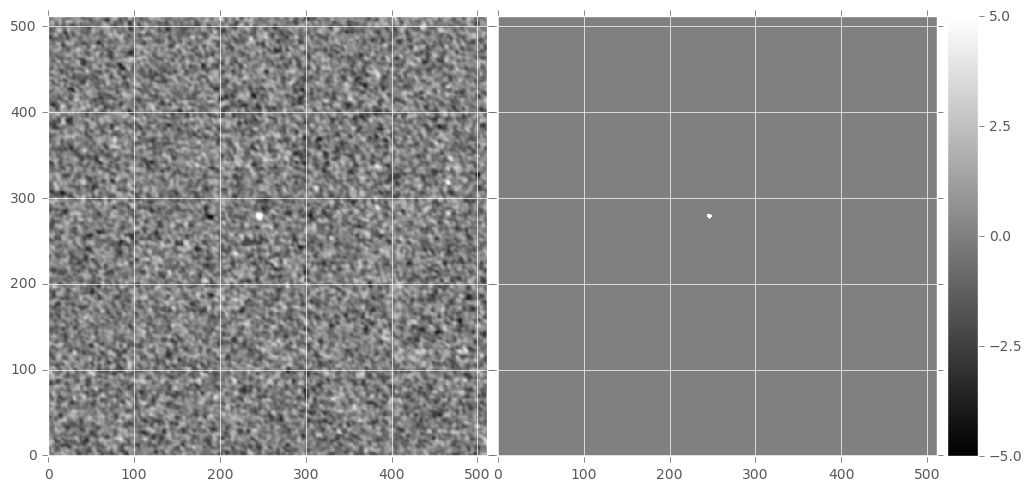

In [7]:
reload(dit);

S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im1, im2, im1_var, im2_var, P_r, P_n)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((S_corr, ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)), clim=(-5.,5.))

Try the matched filtering with the A&L diffim...

(-0.0028450440510942366, 0.94286960872885206, -4.4387599762266872, 8.9295304348848887)
(-1.8146425399776449e-05, 0.0059745796454452318, -0.028056092484686837, 0.0619141756452566)
(245.22193253733903, 348.22282075017586) 0.613731910759
25


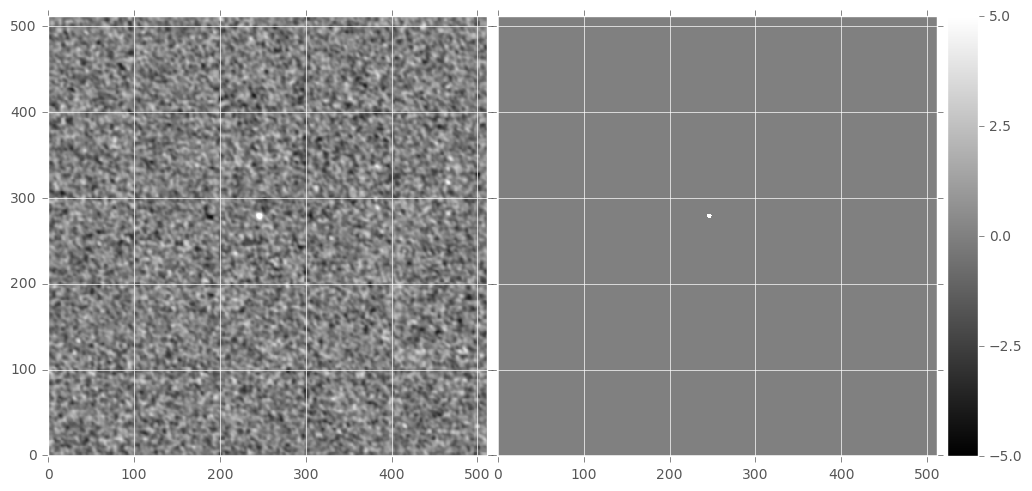

In [8]:
S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im1, im2, im1_var, im2_var, P_r, P_n, D=D_AL)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((S_corr, ((S_corr > 5.)*5.0 + (S_corr < -5.)*-5.0)), clim=(-5.,5.))

### Try the reverse case where science is narrower than template...

In [9]:
reload(dit)
D = dit.performZOGY(im2, im1, im2_psf, im1_psf)
D_AL, _ = dit.performAlardLupton(im2, im1, spatialKernelOrder=0, spatialBackgroundOrder=1)
D_AL /= np.sqrt(sky * 2.)
D_new = dit.performZOGYImageSpace(im2, im1, P_n, P_r)
print dit.computeClippedImageStats(D)
print dit.computeClippedImageStats(D_new)
print dit.computeClippedImageStats(D_AL)

LSSTSW has not been set up.
(0.00088461625274379168, 0.99323103779662691, -4.4838170921378442, 4.8991482476770942)
(0.00093387909492429616, 0.99316652235136338, -4.4849793533753344, 4.8991388073481676)
(-0.0038575717261236332, 0.96629567762346347, -6.7970257674693633, 19.478416806503027)


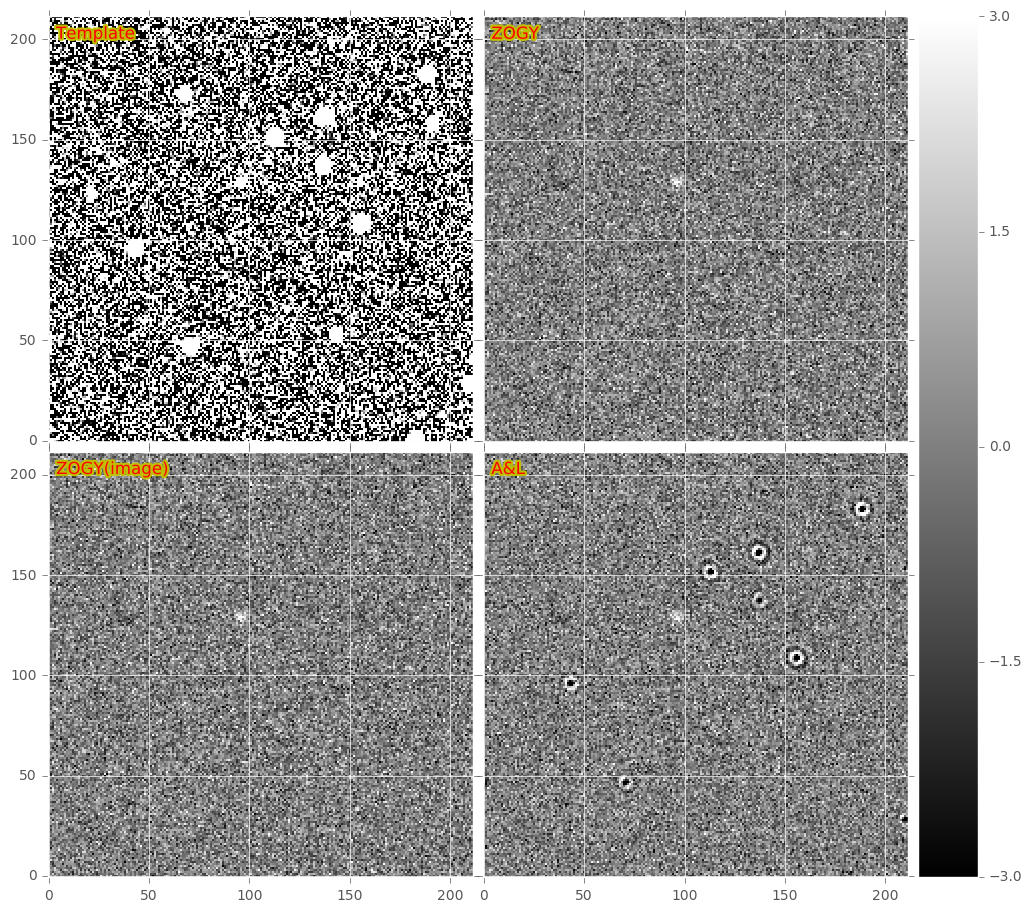

In [10]:
xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
dit.plotImageGrid((im1[x1d:x2d,y1d:y2d], -D[x1d:x2d,y1d:y2d], -D_new[x1d:x2d,y1d:y2d], -D_AL[x1d:x2d,y1d:y2d]), 
                  clim=(-3,3), titles=['Template', 'ZOGY', 'ZOGY(image)', 'A&L'])

LSSTSW has not been set up.
(-0.01078972482564104, 0.97870120675830719, -9.1272042650713381, 4.5284690834150716)
(-6.9142543371464464e-05, 0.0061983037166391149, -0.063284775402083812, 0.028623117289243976)
(245.22193253733903, 348.22282075017586) -0.660360541329
29


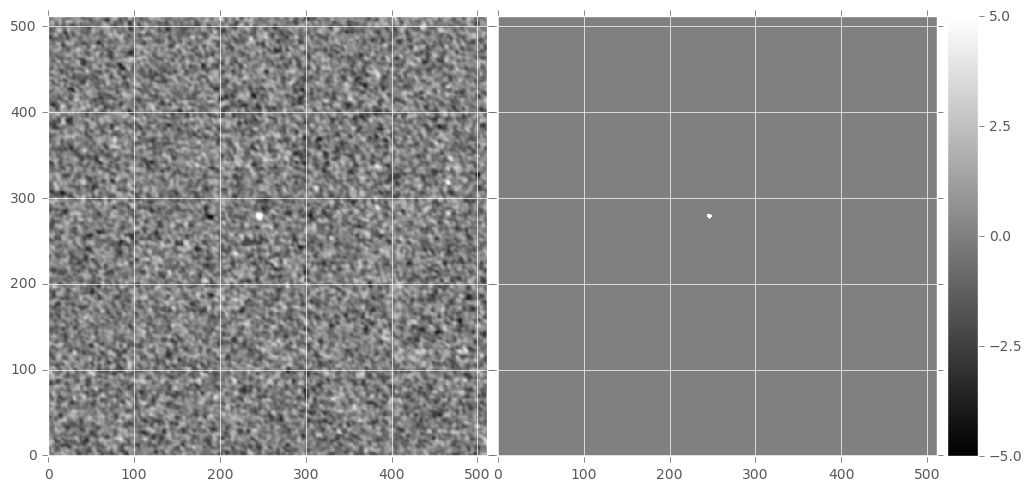

In [11]:
reload(dit);

S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im2, im1, im2_var, im1_var, P_n, P_r)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-S_corr, ((S_corr > 5.)*-5.0 + (S_corr < -5.)*5.0)), clim=(-5.,5.))

S_corr, S, _, P_D, F_D = dit.performZOGY_Scorr(im2, im1, im2_var, im1_var, P_n, P_r, D=D_AL)
print dit.computeClippedImageStats(S_corr)
print dit.computeClippedImageStats(S)
#dit.plotImageGrid((S_corr, S, var1c, var2c), clim=(-2,2))
print changedCentroid, S_corr[np.rint(changedCentroid[1]).astype(int), np.rint(changedCentroid[0]).astype(int)]
print (S_corr > 5.).sum() + (S_corr < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-S_corr, ((S_corr > 5.)*-5.0 + (S_corr < -5.)*5.0)), clim=(-5.,5.))

### But now turn on A&L "preconvolution" with the correct decorrelation kernel enabled...

In [12]:
reload(dit)

# Note kernelSize needs to equal psfSize in makeFakeImages call above

D_AL_pc, kappa = dit.performAlardLupton(im2, im1, spatialKernelOrder=0, spatialBackgroundOrder=1, 
                                        preConvKernel=P_n, doALZCcorrection=False)
D_AL_pc_ALZC, kappa2 = dit.performAlardLupton(im2, im1, spatialKernelOrder=0, spatialBackgroundOrder=1, 
                                        preConvKernel=P_n, doALZCcorrection=True)
print dit.computeClippedImageStats(D_AL_pc)
print dit.computeClippedImageStats(D_AL_pc_ALZC)

LSSTSW has not been set up.
(-0.07071701895648555, 18.814956257653922, -179.12370581003387, 479.66565590349887)
(-0.010231172899141465, 3.4849414855709226, -29.885684786285641, 46.763197168746956)


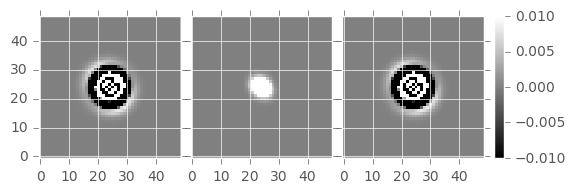

In [13]:
dit.plotImageGrid((kappa, P_n, kappa2), clim=(-0.01,0.01))

(-6.9142543371464464e-05, 0.0061983037166391149, -0.063284775402083812, 0.028623117289243976)
(-0.01078972482564104, 0.97870120675830719, -9.1272042650713381, 4.5284690834150716)


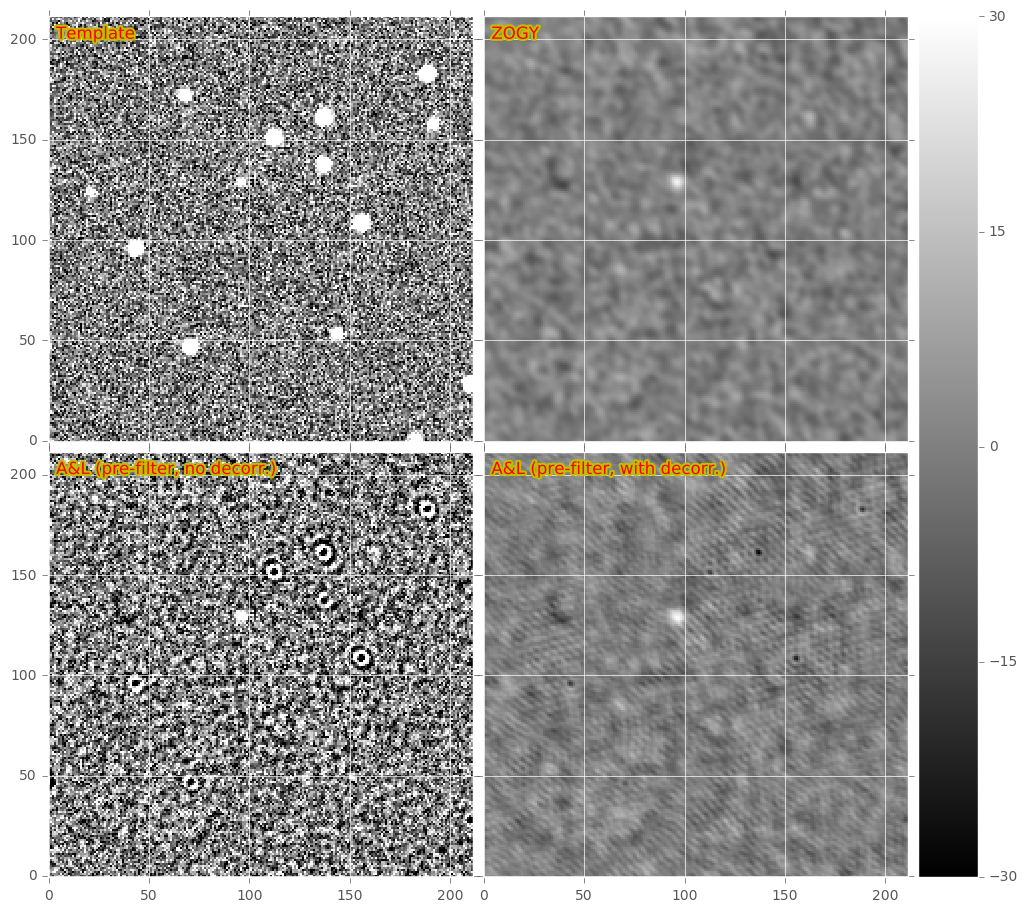

In [14]:
S_corr, S, D, P_D, F_D = dit.performZOGY_Scorr(im2, im1, im2_var, im1_var, P_n, P_r)
print dit.computeClippedImageStats(S)
print dit.computeClippedImageStats(S_corr)

xim = np.arange(-256, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
dit.plotImageGrid((im1[x1d:x2d,y1d:y2d], -S_corr[x1d:x2d,y1d:y2d]*3., -D_AL_pc[x1d:x2d,y1d:y2d], 
                   -D_AL_pc_ALZC[x1d:x2d,y1d:y2d]), 
                  clim=(-30,30), titles=['Template', 'ZOGY', 'A&L (pre-filter, no decorr.)', 
                                         'A&L (pre-filter, with decorr.)'])

(-0.010231172899141465, 3.4849414855709226, -29.885684786285641, 46.763197168746956)
(0.87070617060922384, 0.81161002065026111, -61509.433411703649, 125850.21999988348)
113


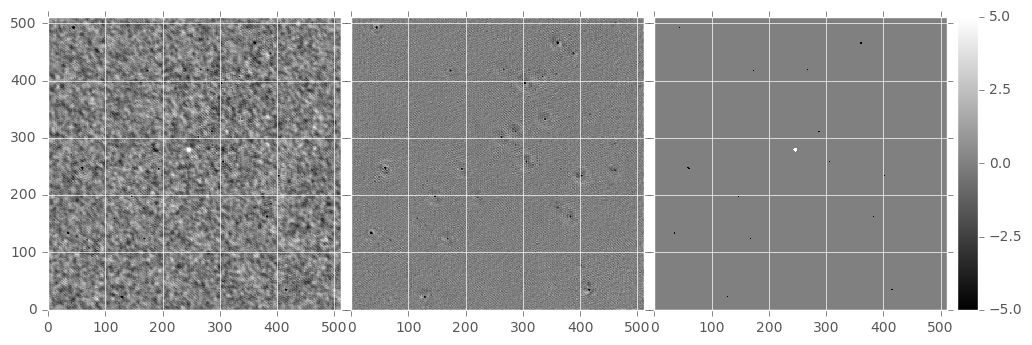

In [15]:
dstats = dit.computeClippedImageStats(D_AL_pc_ALZC)
print dstats
#D_AL_pc_ALZC /= 3.0
tmp = (D_AL_pc_ALZC - dstats[0]) / dstats[1]
print dit.computeClippedImageStats(tmp/S_corr)
print (tmp > 5.).sum() + (tmp < -5.).sum()
fig = plt.figure(1, (12, 12))
dit.plotImageGrid((-tmp, -(tmp-S_corr), ((tmp > 5.)*-5. + (tmp < -5.)*5.)), clim=(-5., 5.))